# Módulos

In [ ]:
import os
import pandas as pd
os.chdir('/content/drive/MyDrive/')
pd.options.display.max_columns = None
pd.options.display.max_rows = 200
import numpy as np
import math

# Módulos para gráficos:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV, KFold
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import as_concordance_index_ipcw_scorer
from sksurv.nonparametric import kaplan_meier_estimator
from tabulate import tabulate

# Funciones

In [ ]:
# @title
def completitud(df):
    comp=pd.DataFrame(df.isnull().sum())
    comp.reset_index(inplace=True)
    comp=comp.rename(columns={"index":"Columna",0:"Total_reg_nulos"})
    comp["Per_completitud"]=(1-comp["Total_reg_nulos"]/df.shape[0])*100
    comp=comp.sort_values(by="Per_completitud",ascending=True)
    return comp

def summary(data: pd.DataFrame, x: str):
    """
    """
    x_min = data[x].min()
    x_max = data[x].max()
    Q1 = data[x].quantile(0.25)
    Q2 = data[x].quantile(0.50)
    Q3 = data[x].quantile(0.75)

    dict = {"Min": x_min, "Q1": Q1, "Q2": Q2, "Q3": Q3, "Max": x_max}
    df = pd.DataFrame(data=dict, index=["Value"])
    print(f"Resumen de {x.capitalize()}: \n")
    print(tabulate(df, headers="keys", tablefmt="psql"))

    fig = plt.figure(figsize=(9, 5))
    plt.subplots_adjust(hspace=0.8)
    #sns.set_palette("Pastel1")

    plt.subplot(221, frameon=True)
    ax1 = sns.distplot(data[x], color="#1f77b4")
    ax1.axvline(
        np.mean(data[x]), color="#9467bd", linestyle="--"
    )  # Add mean to the histogram
    ax1.axvline(
        np.median(data[x]), color="black", linestyle="-"
    )  # Add median to the histogram
    #plt.title(f"{x.capitalize()} Density Distribution",fontsize=11)
    plt.ylabel("Densidad",fontsize=10)
    plt.xlabel(f"{x.capitalize()}",fontsize=10)

    plt.subplot(222, frameon=True)
    ax2 = sns.violinplot(x=data[x], palette="Accent", split=True)
    #plt.title(f"{x.capitalize()} Violinplot",fontsize=11)
    plt.xlabel(f"{x.capitalize()}",fontsize=10)

    plt.subplot(223, frameon=True, sharex=ax1)
    ax3 = sns.boxplot(
        x=data[x], palette="cool", width=0.7, linewidth=0.6, showmeans=True
    )
    #plt.title(f"{x.capitalize()} Boxplot",fontsize=11)
    plt.xlabel(f"{x.capitalize()}",fontsize=10)

    plt.subplot(224, frameon=True, sharex=ax2)
    ax4 = sns.kdeplot(data[x], cumulative=True)
    #plt.title(f"{x.capitalize()} Cumulative Density Distribution",fontsize=11)
    plt.ylabel("Densidad",fontsize=10)
    plt.xlabel(f"{x.capitalize()}",fontsize=10)
    plt.show()


def plot_cat(data,cat,target):

    sns.set(font_scale=0.6)
    subplot_cols = 2
    subplot_rows = int(len(cat)/2 + 1)
    plt.figure(figsize=(15,3*subplot_rows))
    plt.subplots_adjust(hspace=0.3)
    for i, col in enumerate(cat):

          plt.subplot(subplot_rows,subplot_cols,i+1)
          order =data[col].value_counts(ascending=False).index  #orden
          sns.despine(left=False, bottom=True)
          ax=sns.countplot(data=data, x=col, palette = 'Paired', order=order,hue=target)


def n_sample_predict_survival(sample,model):
  surv = model.predict_survival_function(sample, return_array=True)
  for i, s in enumerate(surv):
    plt.step(model.unique_times_, s, where="post", label="muestra %d" % (i + 1))
    #plt.style.use("ggplot2")
    #"seaborn-dark",tableau-colorblind10
    plt.style.use("ggplot")
  plt.title('Predicción de función de supervivencia')
  plt.ylabel("Prob. de supervivencia")
  plt.xlabel("Meses en Libros")
  plt.xlim([13, 60])
  plt.legend(loc='best')
  plt.grid(True)

def n_sample_predict_chf(sample,model):
  surv = rsf_e.predict_cumulative_hazard_function(sample, return_array=True)
  for i, s in enumerate(surv):
    plt.step(rsf_e.unique_times_, s, where="post", label="muestra %d" % (i + 1))

  plt.title('Predicción de función de riesgo acum.')
  plt.ylabel("Riesgo acumulado")
  plt.xlabel("Meses en Libros")
  plt.xlim([13, 60])
  plt.legend(loc='best')
  plt.grid(True)

def plot_KM(df,var,target,tiempos):

    for value in df[var].unique():

        mask = df[var] == value
        time_cell, survival_prob_cell = kaplan_meier_estimator(df[target][mask],
                                                          df[tiempos][mask])
        plt.step(time_cell, survival_prob_cell, where='post',
            label = '%s (n = %d)' % (value, mask.sum()))


    plt.suptitle("Estimación de Kaplan-Meier",fontsize=15)
    plt.title(f"Estrato por: {var.capitalize()}",fontsize=11)
    plt.ylabel('$\hat{S}_{KM}(t)$')
    plt.xlabel('Meses en Libros')
    plt.xlim([13, 60])
    plt.legend(loc='best')


# Lectura de información

In [ ]:
data=pd.read_csv('BankChurners.csv')
data.sample(3)

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
8156,711598533,Existing Customer,43,M,1,High School,Married,$60K - $80K,Blue,36,1,2,3,4255.0,1729,2526.0,0.550,3607,75,0.471,0.406,0.000175,0.99983
6178,788744058,Existing Customer,48,F,2,High School,Married,Unknown,Blue,27,3,1,2,4009.0,1361,2648.0,0.886,4506,80,0.860,0.339,0.000054,0.99995
9618,794494308,Existing Customer,42,M,3,Uneducated,Married,$120K +,Platinum,23,3,4,3,34516.0,2070,32446.0,0.880,13781,102,0.545,0.060,0.000677,0.99932


In [ ]:
data.drop(columns=['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
                  'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'],
                  inplace=True)

In [ ]:
data.shape,data["Attrition_Flag"].value_counts(1)

((10127, 21),
 Existing Customer    0.83934
 Attrited Customer    0.16066
 Name: Attrition_Flag, dtype: float64)

#Nulos
El conjunto no contiene valores faltantes

In [ ]:
completitud(data).sample(3)

,Columna,Total_reg_nulos,Per_completitud
5,Education_Level,0,100.0
10,Total_Relationship_Count,0,100.0
8,Card_Category,0,100.0


# Clasificación de variables:

In [ ]:
# Target
target=['Attrition_Flag']
# Númericas:
num=data.select_dtypes(include="number").columns.to_list()
# Categóricas:
cat=[x for x in data.columns if x not in num+target]

# Revisión de categóricas

## Conteos por clase

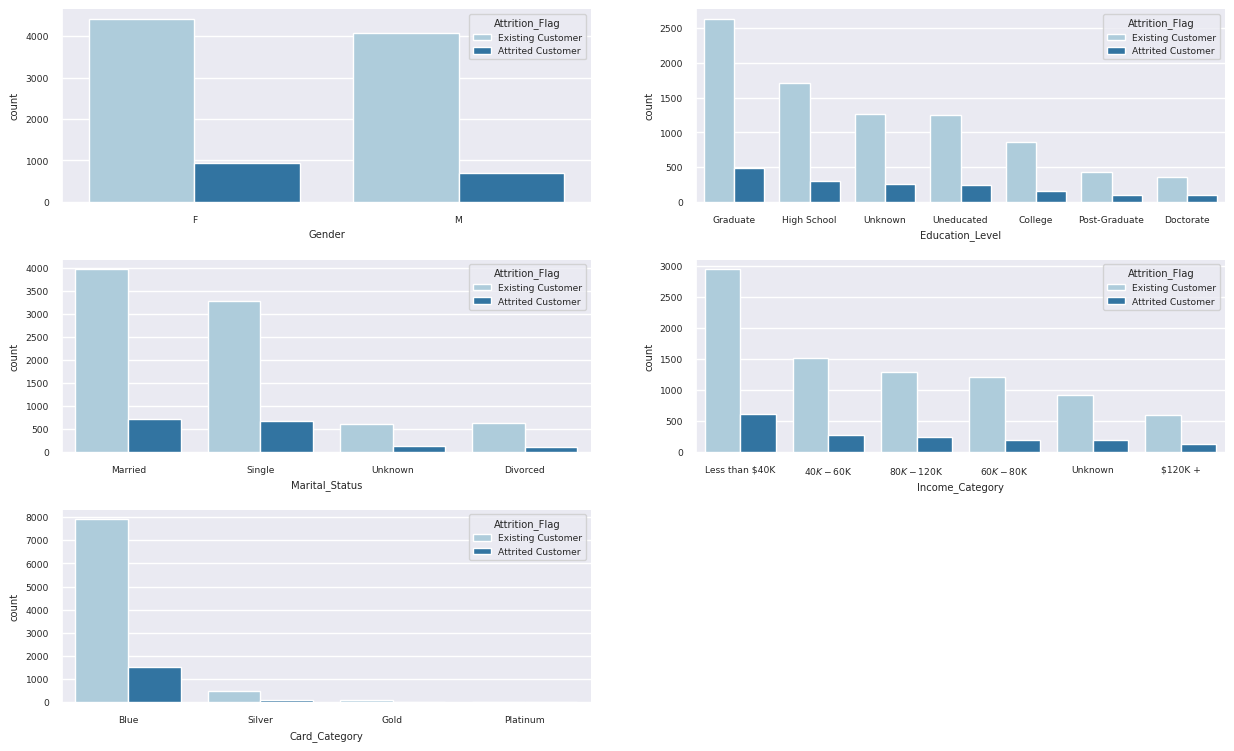

In [ ]:
plot_cat(data,cat,target[0])

##Codificación

In [ ]:
map_Education_Level={"Unknown":-1,"Uneducated":0,"College":1,"High School":2,"Graduate":3,"Post-Graduate":4,"Doctorate":5}
map_Income_Category={"Unknown":-1,"Less than $40K":1,"$40K - $60K":2,"$60K - $80K":3,"$80K - $120K":4,"$120K +":5}
map_Card_Category={"Blue":1,"Silver":2,"Gold":3,"Platinum":4}

data["Education_Level"]=data["Education_Level"].replace(map_Education_Level)
data["Income_Category"]=data["Income_Category"].replace(map_Income_Category)
data["Card_Category"]=data["Card_Category"].replace(map_Card_Category)

In [ ]:
cat.remove("Education_Level")
cat.remove('Income_Category')
cat.remove('Card_Category')

In [ ]:
num=data.select_dtypes(include="number").columns.to_list()

### One Hot Encoding




In [ ]:
df_dumies=pd.get_dummies(data[cat],prefix="dum")
df=pd.merge(data[num],data[target],left_index=True,right_index=True)
df=pd.merge(df,df_dumies,left_index=True,right_index=True)

In [ ]:
dumies=[x for x in df.columns if x.startswith("dum")]
for c in dumies:
  df[c]=df[c].astype(int)

## Codificación de la target

In [ ]:
map_target={"Attrited Customer":1,"Existing Customer":0}
df["Attrition_Flag"]=df["Attrition_Flag"].replace(map_target)
df["Attrition_Flag"]=df["Attrition_Flag"].astype(bool)

# Revisión númericas

--------------------------------------------- Customer_Age ------------------------------------------------------------
Resumen de Customer_age: 

+-------+-------+------+------+------+-------+
|       |   Min |   Q1 |   Q2 |   Q3 |   Max |
|-------+-------+------+------+------+-------|
| Value |    26 |   41 |   46 |   52 |    73 |
+-------+-------+------+------+------+-------+


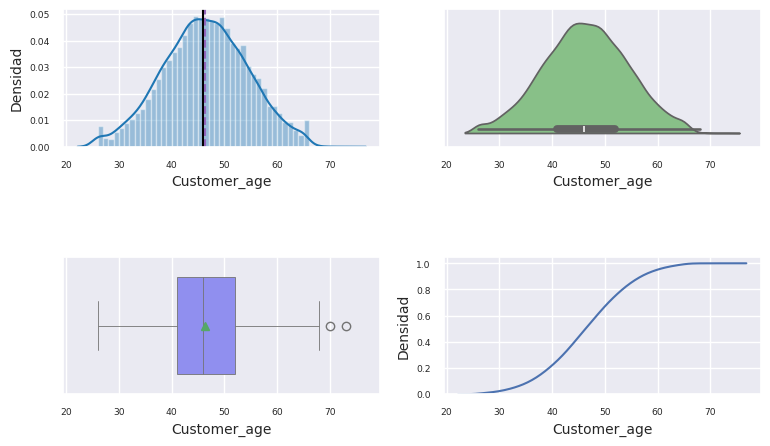

None

--------------------------------------------- Dependent_count ------------------------------------------------------------
Resumen de Dependent_count: 

+-------+-------+------+------+------+-------+
|       |   Min |   Q1 |   Q2 |   Q3 |   Max |
|-------+-------+------+------+------+-------|
| Value |     0 |    1 |    2 |    3 |     5 |
+-------+-------+------+------+------+-------+


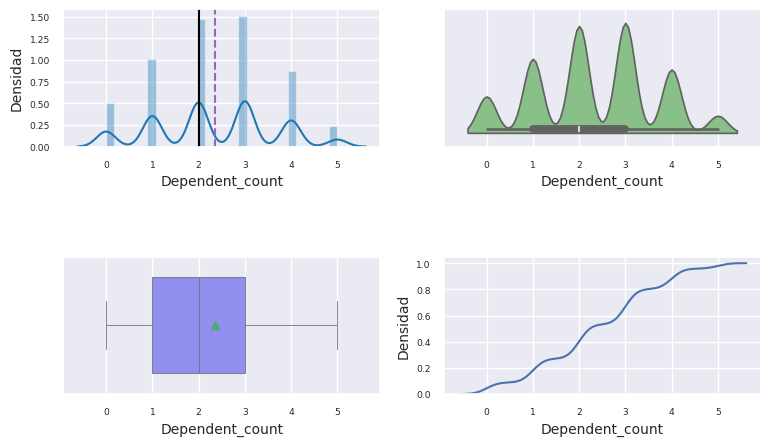

None

--------------------------------------------- Education_Level ------------------------------------------------------------
Resumen de Education_level: 

+-------+-------+------+------+------+-------+
|       |   Min |   Q1 |   Q2 |   Q3 |   Max |
|-------+-------+------+------+------+-------|
| Value |    -1 |    0 |    2 |    3 |     5 |
+-------+-------+------+------+------+-------+


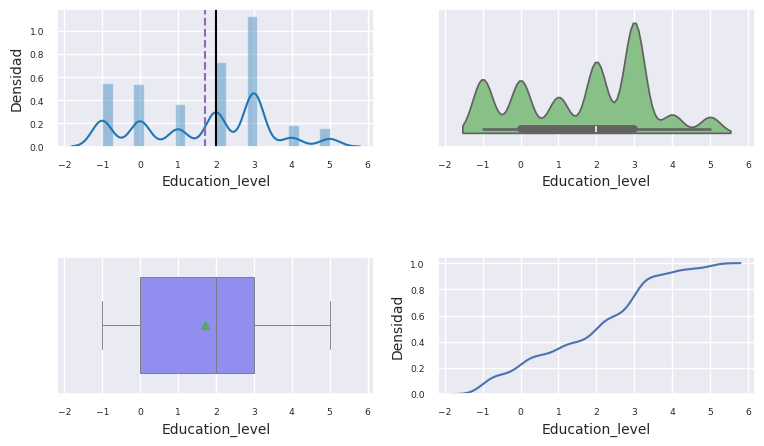

None

--------------------------------------------- Income_Category ------------------------------------------------------------
Resumen de Income_category: 

+-------+-------+------+------+------+-------+
|       |   Min |   Q1 |   Q2 |   Q3 |   Max |
|-------+-------+------+------+------+-------|
| Value |    -1 |    1 |    2 |    3 |     5 |
+-------+-------+------+------+------+-------+


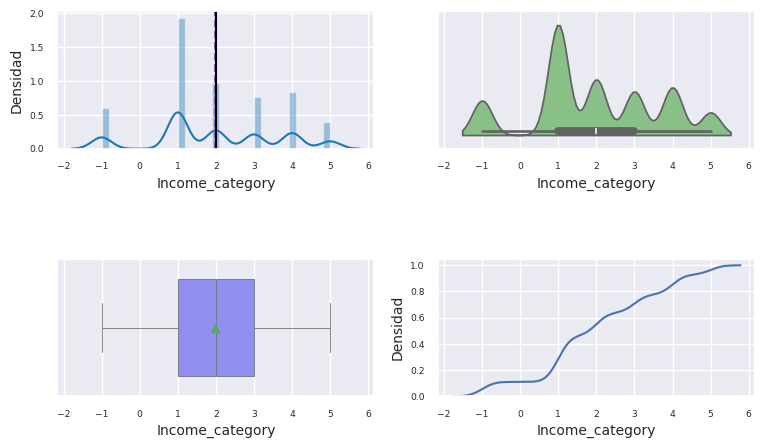

None

--------------------------------------------- Card_Category ------------------------------------------------------------
Resumen de Card_category: 

+-------+-------+------+------+------+-------+
|       |   Min |   Q1 |   Q2 |   Q3 |   Max |
|-------+-------+------+------+------+-------|
| Value |     1 |    1 |    1 |    1 |     4 |
+-------+-------+------+------+------+-------+


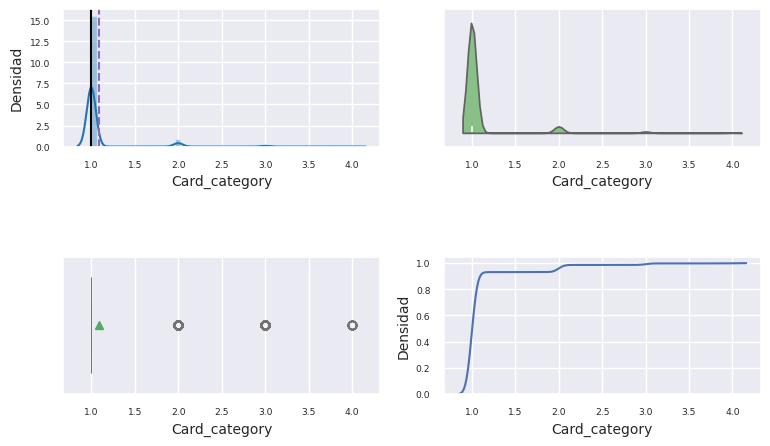

None

--------------------------------------------- Months_on_book ------------------------------------------------------------
Resumen de Months_on_book: 

+-------+-------+------+------+------+-------+
|       |   Min |   Q1 |   Q2 |   Q3 |   Max |
|-------+-------+------+------+------+-------|
| Value |    13 |   31 |   36 |   40 |    56 |
+-------+-------+------+------+------+-------+


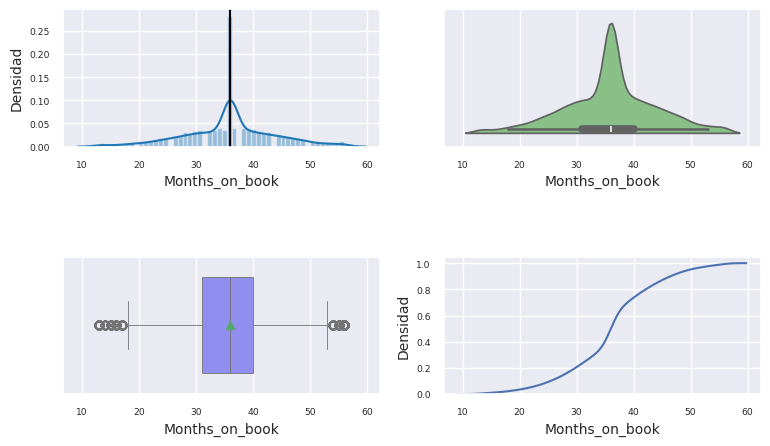

None

--------------------------------------------- Total_Relationship_Count ------------------------------------------------------------
Resumen de Total_relationship_count: 

+-------+-------+------+------+------+-------+
|       |   Min |   Q1 |   Q2 |   Q3 |   Max |
|-------+-------+------+------+------+-------|
| Value |     1 |    3 |    4 |    5 |     6 |
+-------+-------+------+------+------+-------+


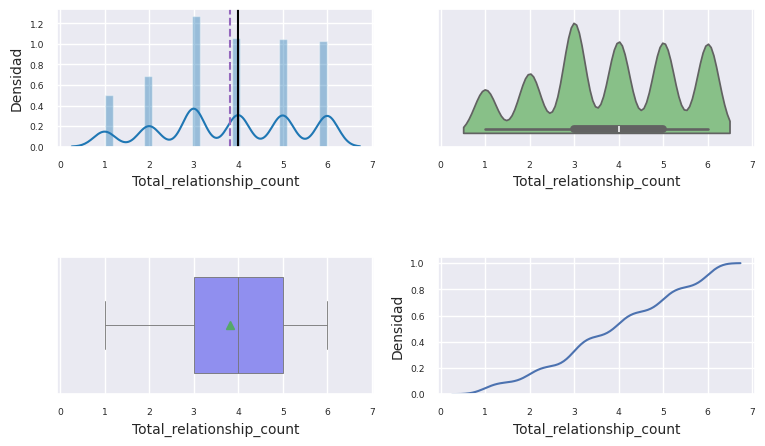

None

--------------------------------------------- Months_Inactive_12_mon ------------------------------------------------------------
Resumen de Months_inactive_12_mon: 

+-------+-------+------+------+------+-------+
|       |   Min |   Q1 |   Q2 |   Q3 |   Max |
|-------+-------+------+------+------+-------|
| Value |     0 |    2 |    2 |    3 |     6 |
+-------+-------+------+------+------+-------+


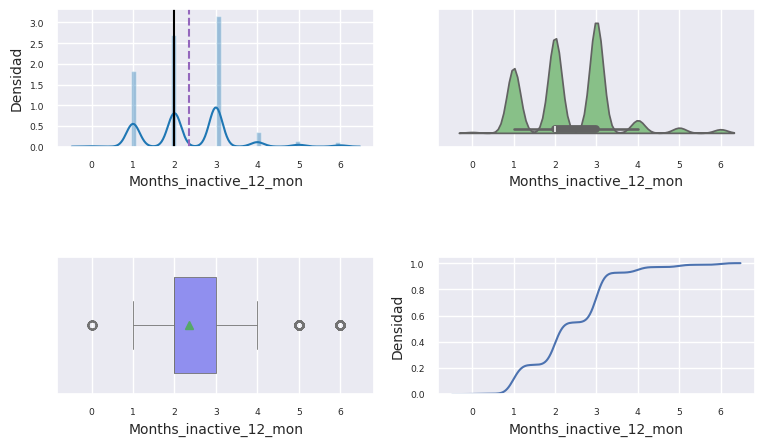

None

--------------------------------------------- Contacts_Count_12_mon ------------------------------------------------------------
Resumen de Contacts_count_12_mon: 

+-------+-------+------+------+------+-------+
|       |   Min |   Q1 |   Q2 |   Q3 |   Max |
|-------+-------+------+------+------+-------|
| Value |     0 |    2 |    2 |    3 |     6 |
+-------+-------+------+------+------+-------+


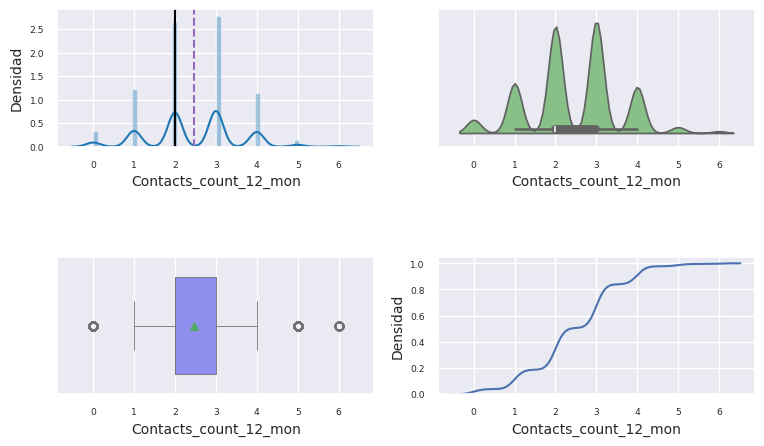

None

--------------------------------------------- Credit_Limit ------------------------------------------------------------
Resumen de Credit_limit: 

+-------+--------+------+------+---------+-------+
|       |    Min |   Q1 |   Q2 |      Q3 |   Max |
|-------+--------+------+------+---------+-------|
| Value | 1438.3 | 2555 | 4549 | 11067.5 | 34516 |
+-------+--------+------+------+---------+-------+


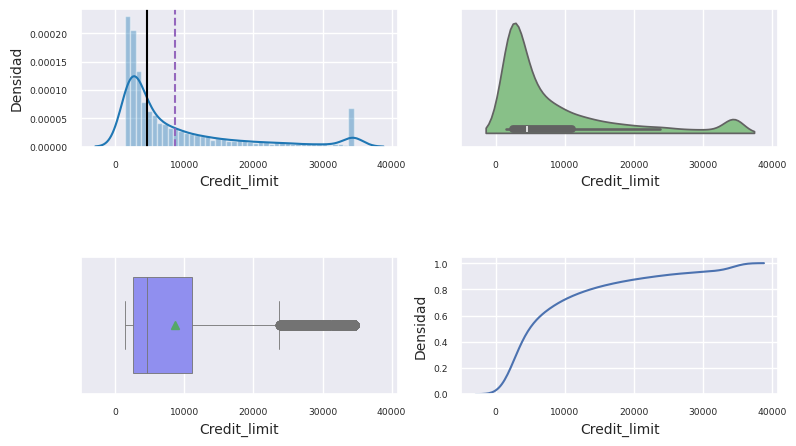

None

--------------------------------------------- Total_Revolving_Bal ------------------------------------------------------------
Resumen de Total_revolving_bal: 

+-------+-------+------+------+------+-------+
|       |   Min |   Q1 |   Q2 |   Q3 |   Max |
|-------+-------+------+------+------+-------|
| Value |     0 |  359 | 1276 | 1784 |  2517 |
+-------+-------+------+------+------+-------+


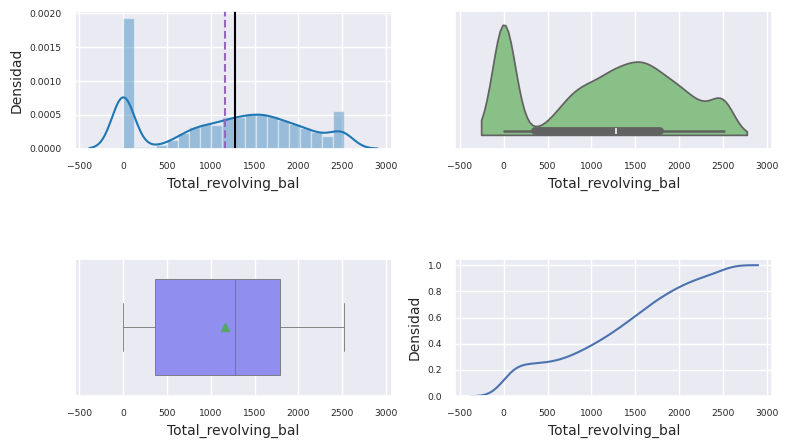

None

--------------------------------------------- Avg_Open_To_Buy ------------------------------------------------------------
Resumen de Avg_open_to_buy: 

+-------+-------+--------+------+------+-------+
|       |   Min |     Q1 |   Q2 |   Q3 |   Max |
|-------+-------+--------+------+------+-------|
| Value |     3 | 1324.5 | 3474 | 9859 | 34516 |
+-------+-------+--------+------+------+-------+


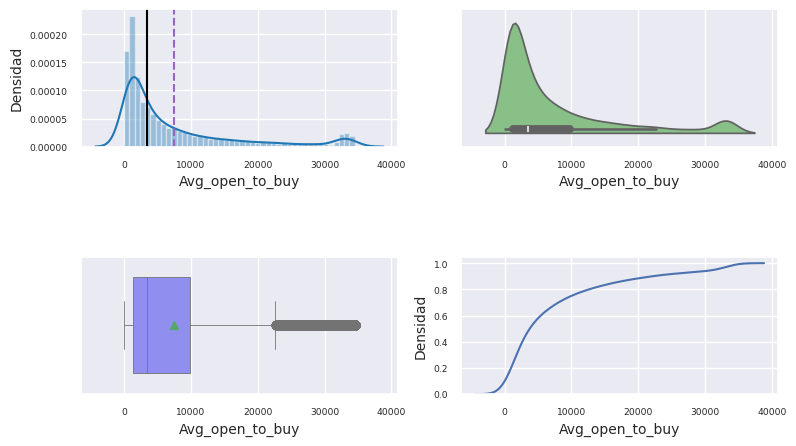

None

--------------------------------------------- Total_Amt_Chng_Q4_Q1 ------------------------------------------------------------
Resumen de Total_amt_chng_q4_q1: 

+-------+-------+-------+-------+-------+-------+
|       |   Min |    Q1 |    Q2 |    Q3 |   Max |
|-------+-------+-------+-------+-------+-------|
| Value |     0 | 0.631 | 0.736 | 0.859 | 3.397 |
+-------+-------+-------+-------+-------+-------+


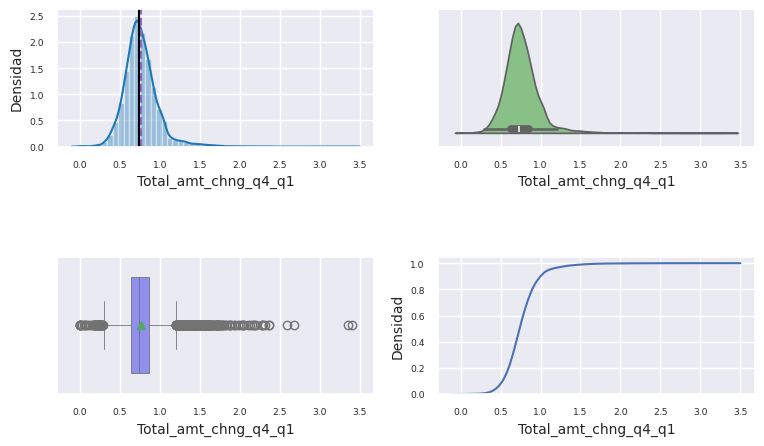

None

--------------------------------------------- Total_Trans_Amt ------------------------------------------------------------
Resumen de Total_trans_amt: 

+-------+-------+--------+------+------+-------+
|       |   Min |     Q1 |   Q2 |   Q3 |   Max |
|-------+-------+--------+------+------+-------|
| Value |   510 | 2155.5 | 3899 | 4741 | 18484 |
+-------+-------+--------+------+------+-------+


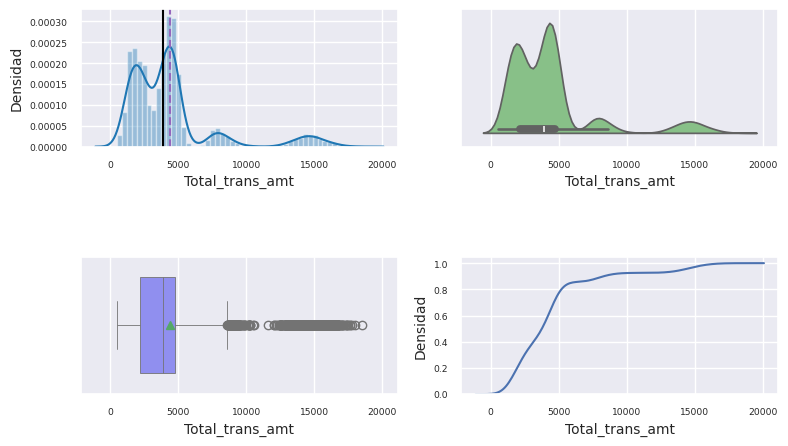

None

--------------------------------------------- Total_Trans_Ct ------------------------------------------------------------
Resumen de Total_trans_ct: 

+-------+-------+------+------+------+-------+
|       |   Min |   Q1 |   Q2 |   Q3 |   Max |
|-------+-------+------+------+------+-------|
| Value |    10 |   45 |   67 |   81 |   139 |
+-------+-------+------+------+------+-------+


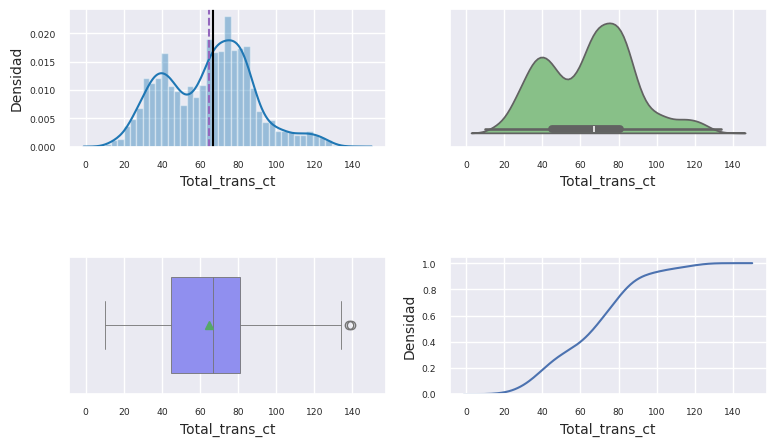

None

--------------------------------------------- Total_Ct_Chng_Q4_Q1 ------------------------------------------------------------
Resumen de Total_ct_chng_q4_q1: 

+-------+-------+-------+-------+-------+-------+
|       |   Min |    Q1 |    Q2 |    Q3 |   Max |
|-------+-------+-------+-------+-------+-------|
| Value |     0 | 0.582 | 0.702 | 0.818 | 3.714 |
+-------+-------+-------+-------+-------+-------+


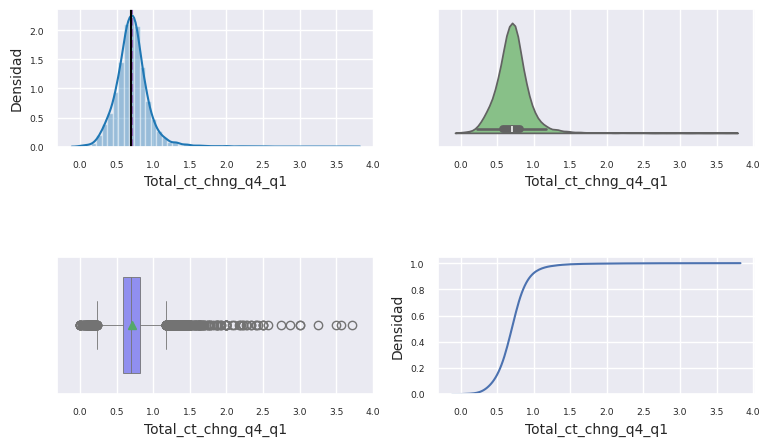

None

--------------------------------------------- Avg_Utilization_Ratio ------------------------------------------------------------
Resumen de Avg_utilization_ratio: 

+-------+-------+-------+-------+-------+-------+
|       |   Min |    Q1 |    Q2 |    Q3 |   Max |
|-------+-------+-------+-------+-------+-------|
| Value |     0 | 0.023 | 0.176 | 0.503 | 0.999 |
+-------+-------+-------+-------+-------+-------+


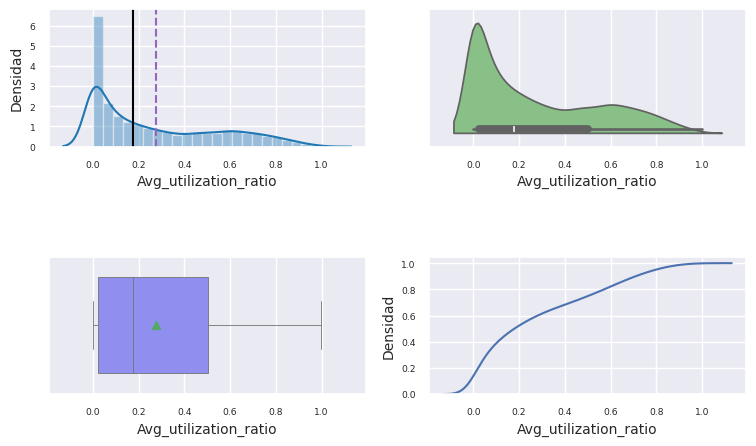

None

In [ ]:
for c in [x for x in num if x not in ["CLIENTNUM"]]:
  print("---"*15,c,"---"*20)
  display(summary(df,c))

## Correlaciones

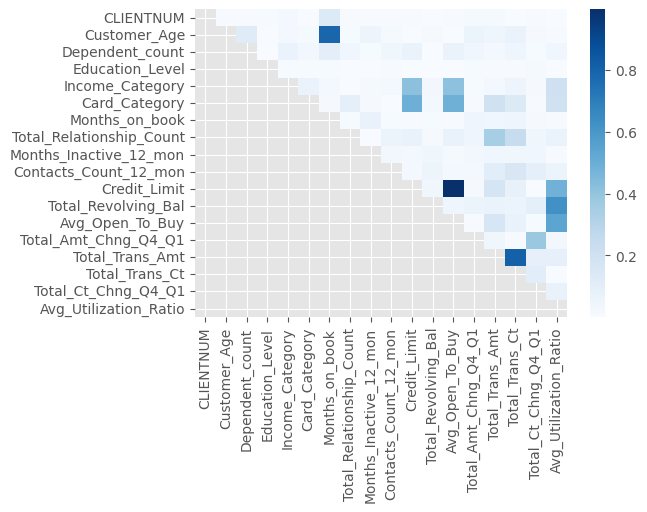

In [ ]:
mat_corr=df[num].corr().abs()
upper = mat_corr.where(np.triu(np.ones(mat_corr.shape), k=1).astype(np.bool))
sns.heatmap(upper,cmap='Blues')
fig=plt.gcf()
fig.set_size_inches(6,4)
plt.show()

In [ ]:
feats_to_drop_corr= [c for c in upper.columns if any(upper[c] > 0.8)]
feats_to_drop_corr

['Avg_Open_To_Buy', 'Total_Trans_Ct']

In [ ]:
# Columnas a eliminar por filtro de correlación de Pearson con un treshold de 0.8.
df.drop(columns=feats_to_drop_corr,inplace=True)

In [ ]:
num.remove('Avg_Open_To_Buy')
num.remove('Total_Trans_Ct')

# Modelado

In [ ]:
random_state = 20
num.remove("CLIENTNUM")
num.remove("Months_on_book")
X=df[num+dumies]
y=df[['Attrition_Flag','Months_on_book']].to_records(index=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=random_state)

## Busqueda de los mejores hipermarámetros

In [ ]:
cv = KFold(n_splits=3, shuffle=True, random_state=1)
cv_param_grid = {"estimator__max_depth": np.arange(100, 150, dtype=int),"tau":[5,10,15]}

In [ ]:
rsf_i = RandomSurvivalForest(random_state)
rsf_i.fit(X_train, y_train)

RandomSurvivalForest(n_estimators=20)

In [ ]:
gcv_cindex = GridSearchCV(
    as_concordance_index_ipcw_scorer(rsf_i, tau=56),
    param_grid=cv_param_grid,
    cv=cv,
    n_jobs=-1,
).fit(X_train, y_train)

In [ ]:
gcv_cindex.best_score_, gcv_cindex.best_params_

(0.9494706134247705, {'estimator__max_depth': 119, 'tau': 15})

# Modelo Final

In [ ]:
rsf_e= RandomSurvivalForest(n_estimators=129, n_jobs=-1, random_state=random_state)
rsf_e.fit(X_train, y_train)

RandomSurvivalForest(n_estimators=129, n_jobs=-1, random_state=20)

### Métricas obtenidas:

In [ ]:
print('C_index en train:',rsf_e.score(X_train,y_train)),
print('C_index en test:',rsf_e.score(X_test,y_test))

C_index en train: 0.9663924565157948
C_index en test: 0.9309038500721114


# Predicción de la función de supervivencia para $n$ muestras en Test


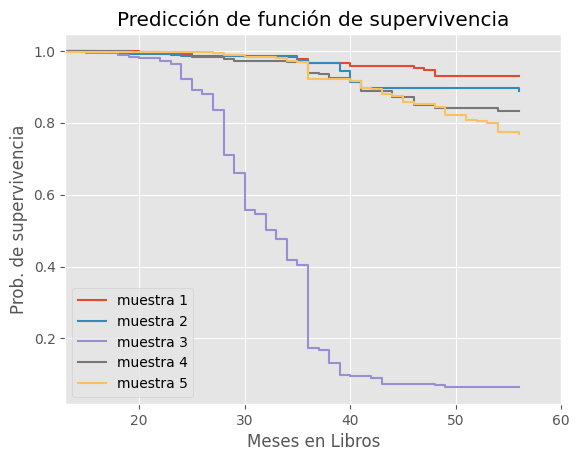

In [ ]:
muestra=X_test.sample(5)
n_sample_predict_survival(muestra,rsf_e)

# Predicción de la función de riesgo acumulada para $n$ muestras en Test

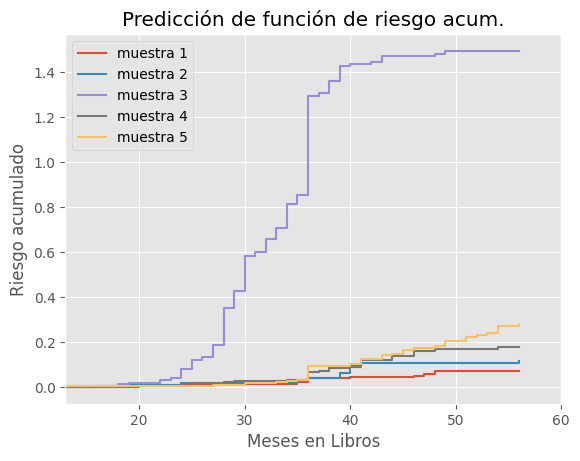

In [ ]:
n_sample_predict_chf(muestra,rsf_e)

# Cálculo del score de riesgo para la muestra

In [ ]:
score_samples=pd.DataFrame(rsf_e.predict(muestra))
score_samples.rename(columns={0:"Risk_score"},inplace=True)
score_samples["muestra"]=score_samples.index+1
score_samples=score_samples[["muestra","Risk_score"]]
score_samples

,muestra,Risk_score
0,1,1.378553
1,2,2.275194
2,3,36.115532
3,4,3.193152
4,5,3.805039


# Predicción del score del score en test:


In [ ]:
X_test_c=X_test.copy()

In [ ]:
X_test_c["Risk_score"]=rsf_e.predict(X_test_c)
X_test_c=pd.merge(X_test_c,df[['Attrition_Flag']],left_index=True,right_index=True, how='inner')
X_test_c["rank_Rscore"]=pd.qcut(X_test_c["Risk_score"],15,labels=False)

In [ ]:
X_test_c.sample(3)

,Customer_Age,Dependent_count,Education_Level,Income_Category,Card_Category,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,dum_F,dum_M,dum_Divorced,dum_Married,dum_Single,dum_Unknown,Risk_score,Attrition_Flag,rank_Rscore
3578,46,2,2,2,1,4,3,2,2619.0,2271,0.610,3835,0.818,0.867,0,1,0,1,0,0,0.932171,False,3
1849,59,0,2,1,1,6,2,4,2833.0,1609,0.780,1335,1.300,0.568,1,0,0,1,0,0,0.155039,False,0
8808,47,2,0,-1,1,2,1,1,15155.0,1287,0.868,7724,0.580,0.085,1,0,0,1,0,0,1.177778,False,4


# Feature importance

In [ ]:
result = permutation_importance(rsf_e, X_test, y_test, n_repeats=15, random_state=random_state)
pd.DataFrame(
    {k: result[k]for k in ( "importances_mean", "importances_std")},
    index=X_test.columns).sort_values(by="importances_mean", ascending=False)

,importances_mean,importances_std
Total_Trans_Amt,0.116663,0.006491
Total_Revolving_Bal,0.036859,0.004778
Customer_Age,0.027622,0.002135
Total_Ct_Chng_Q4_Q1,0.016635,0.001899
Total_Relationship_Count,0.013546,0.001048
Total_Amt_Chng_Q4_Q1,0.011419,0.001732
Avg_Utilization_Ratio,0.008352,0.002035
Credit_Limit,0.003077,0.000859
Contacts_Count_12_mon,0.002439,0.000867
Education_Level,0.001217,0.000373


# Estimación Kaplan Meier para las 5 variables más predictivas

In [ ]:
data_c=data.copy()
data_c["Attrition_Flag"]=data_c["Attrition_Flag"].replace({"Existing Customer":0,"Attrited Customer":1})
data_c["Attrition_Flag"]=data_c["Attrition_Flag"].astype(bool)

In [ ]:
data_c.sample(3)

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
4124,755593983,False,50,F,1,3,Married,-1,1,43,6,1,2,7985.0,0,7985.0,1.032,3873,72,0.674,0.0
4199,717099408,False,40,M,3,3,Married,3,1,29,6,3,2,10529.0,0,10529.0,0.729,4583,87,0.851,0.0
4383,711286533,False,43,M,3,3,Unknown,3,1,31,5,1,2,13448.0,0,13448.0,0.667,5067,62,0.722,0.0


## Creación de rangos

In [ ]:
ranks=[0,1,3,6]
data_c["Total_Relationship_Count_r"]=pd.cut(data_c["Total_Relationship_Count"],ranks)

In [ ]:
feats_imp=["Total_Trans_Amt","Total_Revolving_Bal","Customer_Age","Total_Ct_Chng_Q4_Q1"]
for f in feats_imp:
  data_c[f+"_r"]=pd.cut(data_c[f],4)

## Gráficos KM


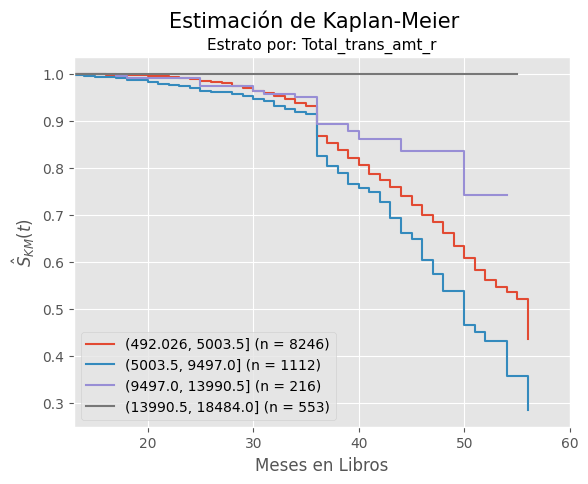

In [ ]:
plot_KM(data_c,"Total_Trans_Amt_r",'Attrition_Flag','Months_on_book')

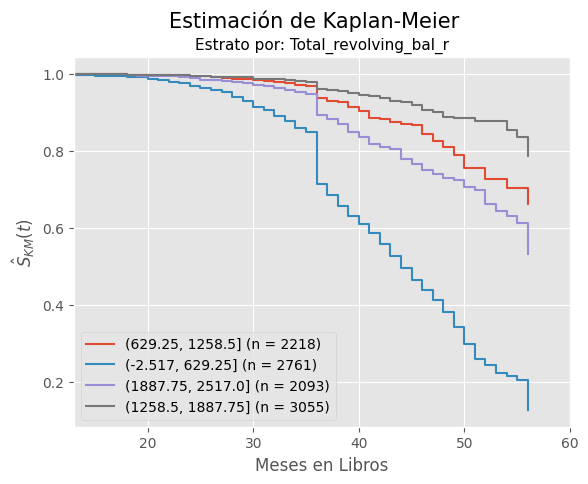

In [ ]:
plot_KM(data_c,"Total_Revolving_Bal_r",'Attrition_Flag','Months_on_book')

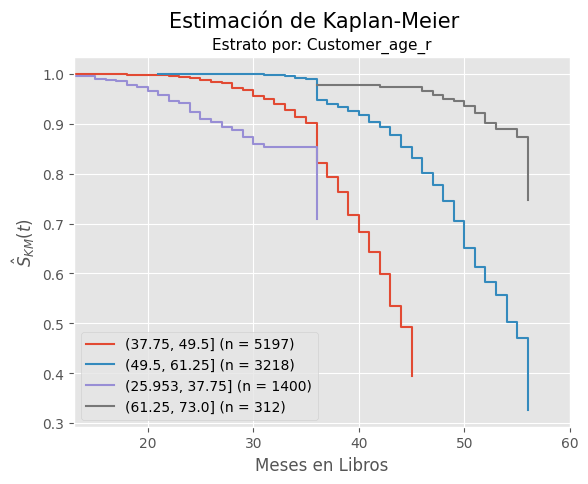

In [ ]:
plot_KM(data_c,"Customer_Age_r",'Attrition_Flag','Months_on_book')

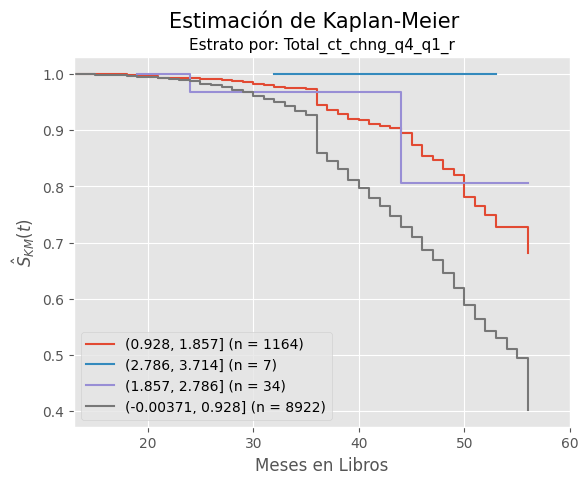

In [ ]:
plot_KM(data_c,"Total_Ct_Chng_Q4_Q1_r",'Attrition_Flag','Months_on_book')

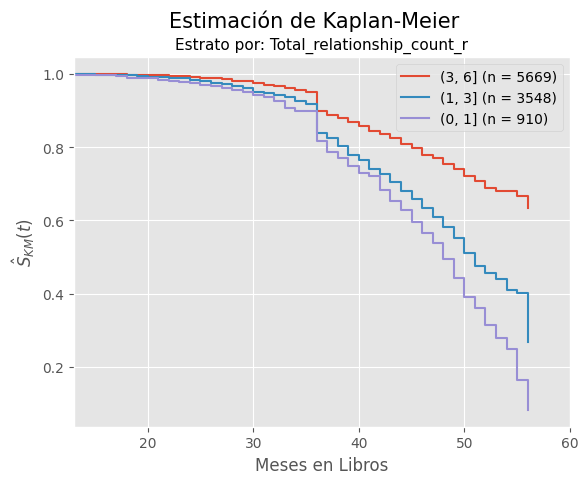

In [ ]:
plot_KM(data_c,"Total_Relationship_Count_r",'Attrition_Flag','Months_on_book')